# Let’s Help Santa!

Go to “Uber Movement” website and download data of Monthly Aggregate (all days), 2017 Quarter 4, for San Francisco area1. The dataset contains pairwise traveling time statistics between most pairs of points in San Francisco area. Points on the map are represented by unique IDs. To understand the correspondence between map IDs and areas, download Geo Boundaries file from the same website2. This file contains latitudes and longitudes of the corners of the polygons circumscribing each area. In addition, it contains one street address inside each area, referred to as DISPLAY NAME. To be specific, if an area is represented by a polygon with 5 corners, then you have a 5 × 2 matrix of the latitudes and longitudes, each row of which represents latitude and longitude of one corner.

## Question 6:
Report the number of nodes and edges in G.

In [2]:
import numpy as np
import pandas as pd
import json as js
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
%matplotlib inline

data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv', header=0, sep=',')
json_data = pd.read_json("san_francisco_censustracts.json")

In [3]:
# Get node attribute and add node to graph
node_dic = {}
G = nx.Graph()

for node_info in json_data['features']:
    node_id = int(node_info['properties']['MOVEMENT_ID'])
    if node_id in node_dic:
        print('WTf')
    else:
        dis_name = node_info['properties']['DISPLAY_NAME']
        location = np.mean(np.array(node_info['geometry']['coordinates'][0][0]), axis=0)
        node_dic[node_id] = {'DISPLAY_NAME':dis_name, 'Location':location}
        G.add_node(node_id, name=dis_name, Location=location)

In [4]:
data_row = data.shape[0]
data_col = data.shape[1]
edge_dic = {}

# Get edges and avg of multi-edges
for idx in range(data_row):
    if int(data['month'][idx]) != 12:
        continue
    edge_w = float(data['mean_travel_time'][idx])
    sourceid = int(data['sourceid'][idx])
    dstid = int(data['dstid'][idx])
    if (sourceid, dstid) in edge_dic:
        edge_dic[(sourceid, dstid)][0] += edge_w
        edge_dic[(sourceid, dstid)][1] += 1
    elif (dstid, sourceid) in edge_dic:
        edge_dic[(dstid, sourceid)][0] += edge_w
        edge_dic[(dstid, sourceid)][1] += 1
    else:
        edge_dic[(sourceid, dstid)] = [edge_w, 1]

In [5]:
# add edges to the graph
for key, item in edge_dic.items():
    w = item[0]/item[1]
    G.add_edge(key[0], key[1], weight=w)
    
Gcc = max(nx.connected_component_subgraphs(G), key=len)

In [6]:
print("Number of nodes are:", nx.number_of_nodes(Gcc))
print("Number of edges are:", nx.number_of_edges(Gcc))

Number of nodes are: 1898
Number of edges are: 321703


## Question 7:
Build a minimum spanning tree (MST) of graph G. Report the street addresses of the two endpoints of a few edges. Are the results intuitive?

In [7]:
MST = nx.minimum_spanning_tree(Gcc)

In [8]:
for point in sorted(nx.edges(MST)):
    print(node_dic[point[0]]["DISPLAY_NAME"], "----", node_dic[point[1]]["DISPLAY_NAME"])

400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 1500 Oxford Street, Palm Park, Redwood City
400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 100 Fifth Avenue, South Fair Oaks, Redwood City
18300 Sutter Boulevard, Morgan Hill ---- 17300 Lotus Way, Morgan Hill
18300 Sutter Boulevard, Morgan Hill ---- 1900 Alpet Drive, Morgan Hill
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 8900 Cal Center Drive, Sacramento
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 9500 River Rose Way, Premier Garden, Sacramento
100 Carlsbad Circle, Vacaville ---- Interstate 505, Vacaville
100 Carlsbad Circle, Vacaville ---- 500 Morningstar Way, Vacaville
Unnamed Road, Vacaville ---- 400 Bowline Drive, Vacaville
Unnamed Road, Vacaville ---- 100 Monte Verde Drive, Vacaville
700 Carlsbad Court, Petaluma ---- 0 Maria Drive, Petaluma
700 Carlsbad Court, Petaluma ---- 200 Ely Road North, Petaluma
700 Carlsbad Court, Petaluma ---- 900 Telford Lane, Petaluma
500 Hyde Street, Tenderloin, San

200 South Avenue, North Sacramento, Sacramento ---- 300 Cleveland Avenue, North Sacramento, Sacramento
7400 Summer Avenue, Citrus Heights ---- 6400 Silkwood Way, Twin Creeks, Citrus Heights
7400 Summer Avenue, Citrus Heights ---- 1000 Windermere Avenue, Cresthaven, Roseville
6400 Silkwood Way, Twin Creeks, Citrus Heights ---- 5700 Greenback Lane, Sacramento
3700 Wood Duck Circle, Lakeview, Stockton ---- 1100 El Monte Street, Pacific, Stockton
600 Lexington Way, Oak Grove Manor, Burlingame ---- 1500 Adrian Road, Ingold - Milldale, Burlingame
600 Lexington Way, Oak Grove Manor, Burlingame ---- 1700 Coyote Point Drive, Shoreview, San Mateo
100 36th Avenue, South San Mateo, San Mateo ---- 3900 Wilshire Avenue, South San Mateo, San Mateo
400 Seventh Avenue, Fair Oaks, Menlo Park ---- 100 Fifth Avenue, South Fair Oaks, Redwood City
400 Seventh Avenue, Fair Oaks, Menlo Park ---- 0 Flood Circle, Lindenwood, Atherton
800 Live Oak Avenue, Downtown Menlo Park, Menlo Park ---- 1200 San Mateo Drive

5300 Lawton Avenue, Shafter, Oakland ---- 6300 Brookside Avenue, Upper Rockridge, Oakland
1100 Cambridge Drive, Lafayette ---- Shore Trail, Lafayette
6500 Horsemans Canyon Drive, Rossmoor, Walnut Creek ---- 2600 Saklan Indian Drive, Rossmoor, Walnut Creek
100 Pinehurst Road, Canyon ---- 0 Ashbrook Place, Corliss, Moraga
1900 Eagle Peak Avenue, Clayton ---- North Peak Road, Clayton
Kestrel Loop Trail, Rodeo ---- 1300 Willow Avenue, Hercules
Kestrel Loop Trail, Rodeo ---- 400 Duperu Drive, Crockett
Stewartville Trail, Antioch ---- 600 Alumrock Drive, Antioch
Stewartville Trail, Antioch ---- 3100 Milner Road, Antioch
Stewartville Trail, Antioch ---- Unnamed Road, Pittsburg
1100 Empire Mine Road, Antioch ---- 600 Alumrock Drive, Antioch
600 Alumrock Drive, Antioch ---- 2600 Yorkshire Drive, Antioch
500 Bourne Lane, Danville ---- 600 Sunflower Court, San Ramon
Tassajara Ridge Trail, San Ramon ---- Rolling Hills Trail, San Ramon
Tassajara Ridge Trail, San Ramon ---- 8100 Morgan Territory Roa

6200 Frazier Lake Road, Gilroy ---- 300 Ioof Avenue, Gilroy
6200 Frazier Lake Road, Gilroy ---- 0 Cordevalle Club Drive, San Martin
700 Meder Street, Santa Cruz ---- 1400 McAllister Way, Santa Cruz
500 Vivienne Drive, Watsonville ---- 0 Brennan Street, Watsonville
700 West Beach Street, Watsonville ---- 200 Jensen Road, Moss Landing
600 Crest Drive, Ben Lomond ---- 10800 Love Creek Road, Ben Lomond
100 Monte Verde Drive, Vacaville ---- 7600 Pleasants Valley Road, Vacaville
100 Monte Verde Drive, Vacaville ---- 200 Madrone Street, Vacaville
1600 Sausalito Drive, Hollister ---- 200 Richardson Road, Hollister
11200 Visitar Street, Felton ---- 10800 Love Creek Road, Ben Lomond
7700 Pitt School Road, Dixon ---- Sikes Road, Dixon
700 Village Drive, Suisun City ---- 900 Delaware Street, Fairfield
7600 Pleasants Valley Road, Vacaville ---- 25400 County Road 29, Winters
200 Riverview Drive, Vallejo ---- 200 Genoa Court, Vallejo
17200 Gehricke Road, Sonoma ---- 17000 Park Avenue, Sonoma
Road 107

## Question 8:
Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

In [9]:
import random

node_scale = max(node_dic.keys())
sample_num = 0
triangle_num = 0
used = set()

while sample_num < 1000:
    sourceid = random.randint(1, node_scale)
    dstid = random.randint(1, node_scale)
    midid = random.randint(1, node_scale)
    if sourceid != midid != dstid and (sourceid, dstid) in edge_dic \
    and (sourceid, midid) in edge_dic and (midid, dstid) in edge_dic \
    and (sourceid, midid, dstid) not in used:
        used.add((sourceid, midid, dstid))
        sample_num += 1
        dij = edge_dic[(sourceid, midid)][0]/edge_dic[(sourceid, midid)][1]
        djk = edge_dic[(midid, dstid)][0]/edge_dic[(midid, dstid)][1]
        dik = edge_dic[(sourceid, dstid)][0]/edge_dic[(sourceid, dstid)][1]
        if dij+djk > dik:
            triangle_num += 1

print(triangle_num/sample_num*100, "% of triangles in the graph satisfy the triangle inequality", sep='')

98.1% of triangles in the graph satisfy the triangle inequality


## Question 9:
Find an upper bound on the empirical performance of the approximate algorithm:
$$\rho = \frac{\text{Approximate TSP Cost}}{\text{Optimal TSP Cost}}$$

In [10]:
# Create multi-graph
Multi_G = nx.MultiDiGraph()
Multi_G.add_nodes_from(MST)
path = []

for edge in MST.edges:
    w = MST.edges[edge]['weight']
    Multi_G.add_edge(edge[0], edge[1], weight=w)
    Multi_G.add_edge(edge[1], edge[0], weight=w)
    
# Find Euler-circle
Euler_circle = nx.eulerian_circuit(Multi_G)

# Calculate the length of the tour from Euler-circle
# (There are multiple Euler-circles, here we only choose the first circle)
travel_length = 0
idx = 0

for edge in Euler_circle:
    if idx == 0:
        start = edge[0]
    if edge[1] == start:
        print(edge[0])
        dst = edge[0]
        path.append(dst)
        print('---------------------------------------')
        break
    travel_length += Multi_G.edges[edge[0], edge[1], 0]['weight']
    path.append(edge[0])
    print(edge[0], "->", end=' ')
    idx += 1
    
print("Approximate TSP cost is:", travel_length)

2 -> 1727 -> 530 -> 1734 -> 2456 -> 531 -> 2378 -> 2607 -> 2240 -> 1852 -> 2240 -> 2607 -> 2378 -> 531 -> 1725 -> 1726 -> 2251 -> 1736 -> 1737 -> 1363 -> 1737 -> 1736 -> 2251 -> 1726 -> 1725 -> 531 -> 2456 -> 1734 -> 530 -> 394 -> 1721 -> 1724 -> 2513 -> 2229 -> 2513 -> 232 -> 2155 -> 347 -> 1851 -> 347 -> 1359 -> 881 -> 562 -> 125 -> 1850 -> 1849 -> 1848 -> 1849 -> 1850 -> 125 -> 562 -> 86 -> 2305 -> 741 -> 345 -> 1833 -> 920 -> 1832 -> 1838 -> 1337 -> 1357 -> 1825 -> 2222 -> 2223 -> 1853 -> 744 -> 2490 -> 744 -> 1869 -> 1361 -> 1358 -> 742 -> 1358 -> 1361 -> 1869 -> 744 -> 1853 -> 2223 -> 2222 -> 1333 -> 1948 -> 1333 -> 829 -> 2656 -> 1949 -> 1937 -> 557 -> 1936 -> 2221 -> 1936 -> 725 -> 1947 -> 725 -> 1936 -> 557 -> 1311 -> 1329 -> 824 -> 1935 -> 1933 -> 1935 -> 1331 -> 1934 -> 2376 -> 1934 -> 2232 -> 1934 -> 1331 -> 1935 -> 1222 -> 2173 -> 724 -> 1330 -> 390 -> 1871 -> 1381 -> 831 -> 745 -> 831 -> 1381 -> 170 -> 1381 -> 1871 -> 563 -> 1872 -> 563 -> 1871 -> 390 -> 1330 -> 724 -> 21

-> 2703 -> 1344 -> 2703 -> 837 -> 1350 -> 924 -> 2033 -> 2425 -> 1230 -> 1231 -> 1230 -> 583 -> 1230 -> 2425 -> 2033 -> 924 -> 1350 -> 837 -> 2703 -> 923 -> 1343 -> 1238 -> 1343 -> 923 -> 2548 -> 1221 -> 10 -> 2076 -> 2446 -> 1954 -> 2501 -> 36 -> 2501 -> 1712 -> 432 -> 1708 -> 1401 -> 229 -> 2500 -> 2444 -> 2492 -> 1321 -> 1320 -> 1785 -> 2645 -> 1785 -> 1786 -> 1785 -> 1784 -> 2309 -> 1301 -> 1787 -> 2467 -> 1326 -> 1208 -> 2493 -> 1208 -> 2306 -> 2325 -> 342 -> 1356 -> 342 -> 2325 -> 2306 -> 1208 -> 1326 -> 2467 -> 1787 -> 2324 -> 526 -> 2324 -> 1787 -> 1301 -> 2309 -> 1784 -> 911 -> 305 -> 969 -> 669 -> 1322 -> 1318 -> 1789 -> 2327 -> 1354 -> 2327 -> 1789 -> 1318 -> 1322 -> 669 -> 969 -> 305 -> 911 -> 1784 -> 1785 -> 1320 -> 1321 -> 2492 -> 2444 -> 2500 -> 229 -> 1401 -> 1708 -> 432 -> 1714 -> 230 -> 115 -> 1719 -> 1717 -> 793 -> 1717 -> 1719 -> 115 -> 1405 -> 1716 -> 1405 -> 973 -> 1405 -> 862 -> 1405 -> 115 -> 1403 -> 115 -> 230 -> 1714 -> 1404 -> 540 -> 2329 -> 231 -> 2329 -> 17

In [11]:
# Get opt_length
opt_length = 0

for edge in MST.edges:
    opt_length += MST.edges[edge]['weight']
    
print("Optimal TSP cost is:", opt_length)

Optimal TSP cost is: 289315.6749999996


In [12]:
print("rho is:", travel_length/opt_length)

rho is: 1.5217849499512983


## Question 10:
Plot the trajectory that Santa has to travel!

Text(0.5, 1.0, 'The trajectory Santa has to travel')

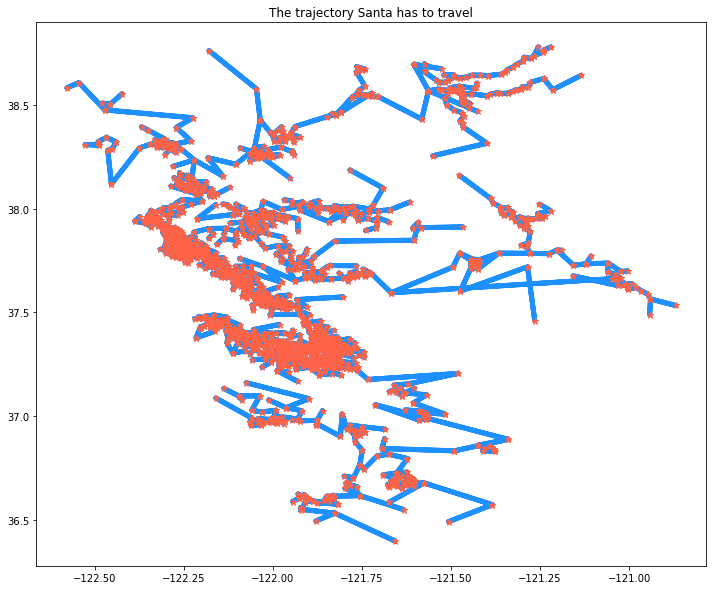

In [13]:
X = []
Y = []

for node in path:
    X.append(node_dic[node]['Location'][0])
    Y.append(node_dic[node]['Location'][1])

# plot the trajectory
plt.figure(figsize=(12, 10))
plt.plot(X, Y, linewidth=5, color='dodgerblue')
plt.plot(X, Y, '*', markersize=7, color='tomato')
plt.title('The trajectory Santa has to travel')

## Question 11:
Plot the road mesh that you obtain and explain the result. Create a graph G∆ whose nodes are different locations and its edges are produced by triangulation.

In [15]:
from scipy.spatial import Delaunay

vertices = nx.nodes(Gcc)
mean_coordinates = np.zeros((len(json_data['features']), 2))
for i in range(len(json_data['features'])):
    mean_coordinates[i, :] = np.mean(json_data['features'][i]['geometry']['coordinates'][0][0], axis=0)
    
mean_coordinates_gcc = mean_coordinates[[x-1 for x in vertices], :]
triangulation = Delaunay(mean_coordinates_gcc)

Text(0.5, 1.0, 'Road Mesh in SF Bay Area')

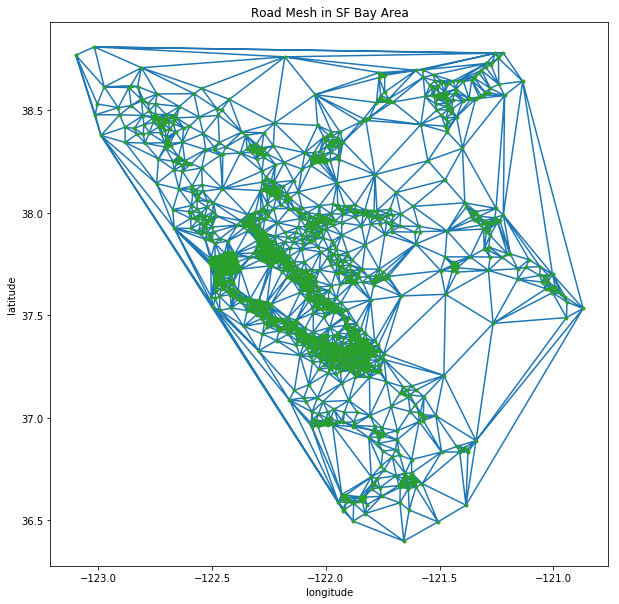

In [18]:
plt.figure(figsize=(10,10))
plt.triplot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], triangulation.simplices)
plt.plot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], '.')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh in SF Bay Area')

In [72]:
G_delta = nx.Graph()

used_nodes = triangulation.simplices
edges_delta = set()
for row in range(used_nodes.shape[0]):
    for index in range(3):   
        node1 = list(vertices)[used_nodes[row][index]]
        node2 = list(vertices)[used_nodes[row][(index + 1) % 3]]
        if (node1, node2) not in edges_delta and (node2, node1) not in edges_delta:
            edges_delta.add((node1, node2))
            G_delta.add_edge(node1, node2)
#         if (node1, node2) in edge_dic or (node2, node1) in edge_dic and \
#         (node1, node2) not in edges_delta and (node2, node1) not in edges_delta:
#             edges_delta.add((node1, node2))
#             if (node1, node2) in edge_dic:
#                 weight = edge_dic[(node1, node2)][0] / edge_dic[(node1, node2)][1]
#                 G_delta.add_edge(node1, node2, weight=weight)
#             else:
#                 weight = edge_dic[(node2, node1)][0] / edge_dic[(node2, node1)][1]
#                 G_delta.add_edge(node2, node1, weight=weight)
                
print("Number of nodes in G_delta:", nx.number_of_nodes(G_delta))
print("Number of edges in G_delta:", nx.number_of_edges(G_delta))

Number of nodes in G_delta: 1898
Number of edges in G_delta: 5680


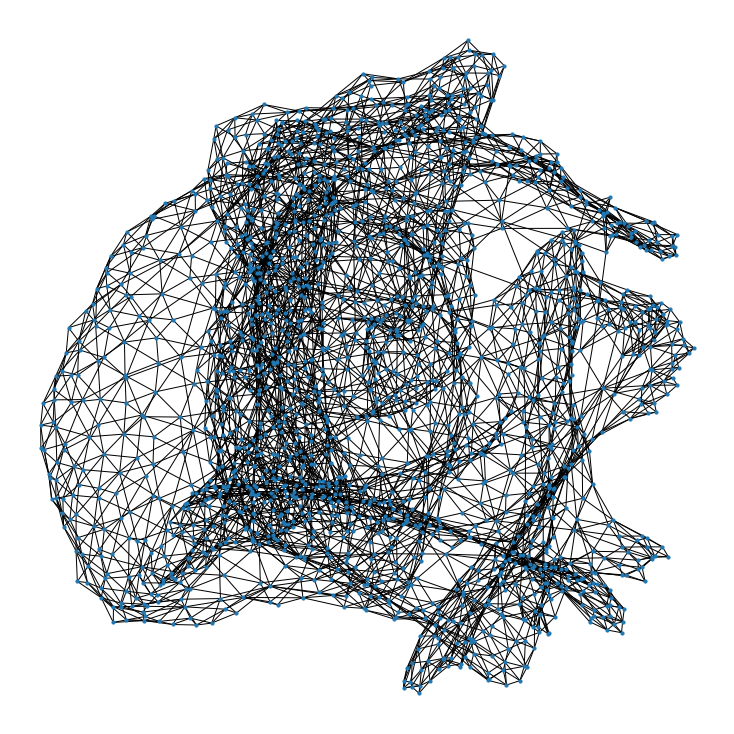

In [73]:
plt.figure(figsize=(10,10))
nx.draw(G_delta, node_size=10)

## Question 12:  
Using simple math, calculate the traffic flow for each road in terms of cars/hour. Report your derivation.  
Consider the following assumptions:

• Each degree of latitude and longitude ≈ 69 miles  
• Carlength≈5m=0.003mile  
• Cars maintain a safety distance of 2 seconds to the next car  
• Each road has 2 lanes in each direction  

Assuming no traffic jam, consider the calculated traffic flow as the max capacity of each road.

In [78]:
miles_per_degree = 69
car_len = 0.003

edges_delta = nx.edges(G_delta)

for edge in list(edges_delta):
    u = edge[0]
    v = edge[1]
    mean_time = 1
    if (u, v) in edge_dict:
        mean_time = edge_dict[(u, v)][0] / edge_dict[(u, v)][1]
    elif (v, u) in edge_dict:
        mean_time = edge_dict[(v, u)][0] / edge_dict[(v, u)][1]
        
    miles = np.sqrt(np.square(
                    abs(node_dict[u]['Location'][0] - node_dict[v]['Location'][0]) * miles_per_degree +
                    abs(node_dict[u]['Location'][1] - node_dict[v]['Location'][1]) * miles_per_degree
                )
           )
    
    car_speed = miles / mean_time
print(list(edges_delta)[0])

(1444, 2017)


## Question 13:

Calculate the maximum number of cars that can commute per hour from Stanford to UCSC. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match what you see on your road map?

In [71]:
Stanford_ID = 0
UCSC_ID = 0

for key in node_dic:
    if node_dic[key]['DISPLAY_NAME'] == '100 Campus Drive, Stanford':
        Stanford_ID = key
    if node_dic[key]['DISPLAY_NAME'] == '700 Meder Street, Santa Cruz':
        UCSC_ID = key
        
print("Stanford node id:", Stanford_ID)
print("UCSC node id:", UCSC_ID)

Stanford node id: 2607
UCSC node id: 1968
